# FLAG DECEPTIVE REVIEWS

In [22]:
# Global Import
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import matplotlib.pylab as py
import matplotlib.pyplot as plt
from IPython.display import HTML
from datetime import datetime, date, time
from sklearn.svm import LinearSVC
from string import punctuation
import csv
import nltk
import re
import requests
import string
import numpy
import os
import pandas as pd
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

import json
%matplotlib inline


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kuhupandey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kuhupandey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/kuhupandey/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [23]:
def dataset_join(path,polarity):
    df = pd.DataFrame(columns=['text','deceptive'])
    for directory in os.listdir(path):
        sub_directory = os.path.join(path, directory)
        if os.path.isdir(sub_directory):
            for filename in os.listdir(sub_directory):
                if not filename.startswith('.'):
                    sub_directory2 = os.path.join(sub_directory, filename)
                    for txt_file in os.listdir(sub_directory2):
                        with open(os.path.join(sub_directory2, txt_file)) as f:
                            txt_file = f.read()
                            current_df = pd.DataFrame({'text': [txt_file],'deceptive':polarity})
                            df = df.append(current_df, ignore_index=True)
    return df


def text_cleaning(text):
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text


def extract_content_based_features(input_data): 
    length = [len(data) for data in input_data]
    tokens = [nltk.word_tokenize(data) for data in input_data]
    taggeds = [nltk.pos_tag(token,tagset='universal') for token in tokens] 
    tag_fds = [nltk.FreqDist(tag for (word, tag) in tagged) for tagged in taggeds]
    verb_minus_noun = [tag_fd['VERB'] - tag_fd['NOUN'] for tag_fd in tag_fds]
    punctuation_amount = [len(re.findall('['+punctuation+']', data)) for data in input_data]
    features = {'punctuation_amount': punctuation_amount,'verb_minus_noun': verb_minus_noun}
    return pd.DataFrame(features)

def extract_ngram_1_3_features(tfidVect,input_data):
    XInput = TfidfVect.transform(input_data).toarray()
    return pd.DataFrame(XInput)

def extract_text_features(tfidVect, input_data):
    df1= extract_content_based_features(input_data)
    df2= extract_ngram_1_3_features(tfidVect,input_data)
    ## extract_ngram (1 3) features
    result = pd.concat([df1, df2], axis=1, join='inner')
    return result

In [24]:
df_negative = dataset_join('op_spam_v1.4/negative_polarity', 1)
df_positive = dataset_join('op_spam_v1.4/positive_polarity', 0)

df_opinion = df_negative.append(df_positive, ignore_index=True)

df_opinion['text']=df_opinion['text'].apply(text_cleaning)


In [25]:
# define the TfidfVect. 
min_df=3
max_df=0.96
# ngram (1,3) gives better percsion than 1,2 and 1,4 doesn't improve accuracy. 
ngram_range = (1,3) 
TfidfVect= TfidfVectorizer(min_df = min_df, max_df = max_df, ngram_range = ngram_range)

**Classification Report**

              precision    recall  f1-score   support

           0       0.95      0.94      0.94        77
           1       0.94      0.95      0.95        83

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160

**Confusion Matrix**

[[72  5]
 [ 4 79]]


/Users/kuhupandey/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


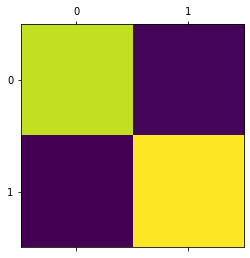

In [26]:
# split the dataset in training and test set:
docs_train, docs_test, y_train, y_test = train_test_split(
    df_opinion['text'], df_opinion['deceptive'].values, test_size=0.10, random_state=None)

TfidfVect.fit(docs_train)
# define featuers from yelp user/business meta-data. 

Xtrain=extract_text_features(TfidfVect, docs_train)
Xtest=extract_text_features(TfidfVect, docs_test)
clf  = LinearSVC(C=100)
clf.fit(Xtrain, y_train.astype('int'))
y_predicted = clf.predict(Xtest)

print("**Classification Report**\n")
print(metrics.classification_report(y_test.astype('int'), y_predicted))
print("**Confusion Matrix**\n")
cm = metrics.confusion_matrix(y_test.astype('int'), y_predicted)
print(cm)

plt.matshow(cm)
plt.show()

In [27]:
def gen(file_name):
    with open(file_name) as fh:
        line = fh.readline()
        while line:
            yield json.loads(line)
            line = fh.readline()

def build_csv_dataset(path, file_name, n_lines, fields):
    
    line_gen = gen(path)
    
    with open(f'{file_name}.csv', 'w') as f:
        csv_writer = csv.writer(f)
        
        i = 0
        for line in line_gen:
            if i == 0:
                csv_writer.writerow(fields)
                i += 1
            row = {k: line[k] for k in line.keys() if k in fields}.values()
            csv_writer.writerow(row)
            i += 1
            
            if i % 1000 == 0 :
                print(f'Processed {i}/{n_lines} lines', end="\r")

            if i == n_lines:
                break
        print('all done!')    



In [28]:
build_csv_dataset('yelp_dataset/yelp_academic_dataset_review.json','reviews',100000, ('user_id', 'business_id', 'stars', 'text'))
build_csv_dataset('yelp_dataset/yelp_academic_dataset_business.json','business',100000,('business_id','name','stars','review_count'))
build_csv_dataset('yelp_dataset/yelp_academic_dataset_user.json','user',100000,('user_id','review_count',"friends","average_stars"))

all done! 100000/100000 lines
all done! 100000/100000 lines
all done! 100000/100000 lines


In [29]:
#reviews_file = 'mass_yelp_academic_dataset_resturants_reviews.json' 
reviews_file = 'yelp_dataset/yelp_academic_dataset_review.json'
business_file = 'yelp_dataset/yelp_academic_dataset_business.json'
user_file = 'yelp_dataset/yelp_academic_dataset_user.json'

reviews_df = pd.read_csv("reviews.csv")
business_df =  pd.read_csv("business.csv")
user_df =  pd.read_csv("user.csv")

In [30]:
business_df.head()

,business_id,name,stars,review_count
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,4.0,86
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,4.0,126
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4.5,13
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,3.0,8
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,4.0,14


In [31]:
## prepare the metadata for merge. 
user_df.rename(columns={'review_count': 'user_review_count'}, inplace=True)
business_df.rename(columns={'review_count': 'business_review_count','stars':'business_stars'}, inplace=True)

## filter out negative or netural reviews, 
reviews_df=reviews_df[reviews_df['stars']>=4]

In [32]:
def extract_metadata_featuers(input_reviews):
    #fill the user and buiness data from other data frames
    merged_data=pd.concat([input_reviews,business_df, user_df], axis=1, join='inner')
    # replace the list of friends with friends count.
    merged_data['friends']  = merged_data['friends'].apply(lambda x: len(x))
    # extract the interesting data only
    return merged_data[['user_review_count','average_stars','friends','business_review_count','business_stars']]
    

In [33]:
from sklearn.covariance import EllipticEnvelope
# Now that we filter out the negative reviews and select the interesting featuers from user/business metadat, it is time
# to train the outlier detector model. 
anomaly_detector = EllipticEnvelope(contamination=0.15)

#ad_docs_train, ad_docs_test = train_test_split(df, test_size=0.10, random_state=None)
anomaly_detector.fit(extract_metadata_featuers(reviews_df))

EllipticEnvelope(contamination=0.15)

In [34]:
def offline_outlier_detector_then_clf(input_data):
    f = extract_metadata_featuers(input_data)
    ad_result = anomaly_detector.predict(f)
    Xinput=extract_text_features(TfidfVect, input_data['text'])
    clf_result = clf.predict(Xtest)
    return [clf_result if (ad_result==-1) else 1 for clf_result,ad_result in zip(clf_result,ad_result)]
    
offline_outlier_detector_then_clf(reviews_df[1:4])

[1, 1, 1]

In [35]:
from urllib.parse import quote
# API constants
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'
api_key = "yNmgmV9jq-RFzNW_0PfPJ-TFBJ9d3CWrI1VHuv2qT7ai9rlBBPq7HviMCmpA9gJEtSAN9bjMFEkr0Cm_yyeMuaAD4WZL62-DU08HmSyFpSmeCHo5-vwlIekS_0uwYXYx"
SEARCH_LIMIT = 1

def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()


def get_business(term, location):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT
    }
    request_1 = request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)
    business_id = request_1['businesses'][0]['id']
    request_2 = request(API_HOST, BUSINESS_PATH + business_id+"/reviews", api_key)
    return {'review':request_2['reviews'][0]['text'], 'rating':request_2['reviews'][0]['rating'], 
           'review_count':request_1['businesses'][0]['review_count'], 'business_stars':request_1['businesses'][0]['rating']}


In [36]:
# test, fetch cider mill first review.

response=get_business('cider mill','syracuse')
response['review']

Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/VhUGLVBGu9aDMLdf39yx0A/reviews ...


'By far one of the most friendliest and attentive brewery I have been to. I believe the owner was the one checking on everyone and even brought water bowls...'

In [37]:
def online_detector_using_rest_api(business, location):
    response= get_business(business, location)
    business_review_count = response['review_count']
    business_stars = response['business_stars']
    text=response['review']
    rating=response['rating']
    print()
    print(f'extracted the review {text}')
    # YELP doesn't allow fetching user friends count,review_count, use 1, later use CRAWL to get that number from html page,.
    count = 1
    features_=pd.DataFrame({'user_review_count' :[count,0], 'average_stars':[rating,0],'friends':[count,0],'business_review_count':[business_review_count,0],'business_stars':[business_stars,0]})
    ad_result = anomaly_detector.predict(features_)
    # if not outlier, return real
    if ad_result[0]==1:
        return f"review is truthful"
    else:
        # Outlier, check using text classifer. 
        #vectorize the review text.
        Xinput_=extract_text_features(TfidfVect, [text])
        clf_result = clf.predict(Xinput_)
        return f"review is truthful" if clf_result[0]==1 else f"review is deceptive"
    

In [38]:
online_detector_using_rest_api('cider mill','syracuse')

Querying https://api.yelp.com/v3/businesses/search ...
Querying https://api.yelp.com/v3/businesses/VhUGLVBGu9aDMLdf39yx0A/reviews ...

extracted the review By far one of the most friendliest and attentive brewery I have been to. I believe the owner was the one checking on everyone and even brought water bowls...


'review is truthful'

In [1]:
#Future implementation

In [2]:
def deceptive_checker_1(text):
    url = 'http://fake-review-detector'
    payload = {'review_text': text}
    r = requests.post(url, data=payload)
    return r.text

In [3]:
review1='Best restaurant. Charlie is extremely nice and friendly. I recommend all the food, especially chicken  plate and sandwich. You wont get disappointed'
deceptive_checker_1(review1)